In [ ]:
from typing import Optional, Tuple

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
import IPython.display as ipd

# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Mini-GSC

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 2s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(commands)

['left' 'yes' 'stop' 'go' 'down' 'no' 'up' 'right']


In [ ]:
train_ds, val_ds = keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    batch_size = 64,
    validation_split = 0.2,
    seed = 0,
    output_sequence_length = 16000,
    subset = 'both'
)

label_names = np.array(train_ds.class_names)
print()
print('label names:', label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [ ]:
X, y = next(iter(train_ds))
X.shape

TensorShape([64, 16000, 1])

In [ ]:
X[0, :5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.02914429],
       [0.03070068],
       [0.03295898],
       [0.03414917],
       [0.0383606 ]], dtype=float32)>

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
X, y = next(iter(train_ds))
X.shape

TensorShape([64, 16000])

In [ ]:
test_specs, test_labels = next(iter(test_ds))

## Convert to Spectrogram

In [ ]:
class Spectrogram(keras.Model):
    def __init__(self,
                 sample_rate: int = 16000,
                 n_fft: int = 400,
                 win_length: Optional[int] = None,
                 hop_length: Optional[int] = None,
                 pad_end: bool = False,
                 power: float = 2.0) -> None:
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else win_length//2
        self.pad_end = pad_end
        self.power = power

    def call(self, waveform: tf.Tensor) -> tf.Tensor:
        spectrogram = tf.abs(tf.signal.stft(
                signals = waveform,
                frame_length = self.win_length,
                frame_step = self.hop_length,
                fft_length = self.n_fft,
                pad_end = self.pad_end
            ))
        if self.power == 2:
            spectrogram = spectrogram*spectrogram
        return spectrogram

In [ ]:
class MelSpectrogram(keras.Model):
    def __init__(self,
                 sample_rate: int = 16000,
                 n_fft: int = 400,
                 win_length: Optional[int] = None,
                 hop_length: Optional[int] = 160,
                 f_min: float = 0.0,
                 f_max: float = 3800,
                 pad_end: bool = False,
                 n_mels: int = 128,
                 power: float = 2.0,
                 power_to_db: bool = True) -> None:
          super().__init__()
          num_spectrogram_bins = n_fft//2+1
          self.spec = Spectrogram(sample_rate,
                                  n_fft,
                                  win_length,
                                  hop_length,
                                  pad_end,
                                  power)
          self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
              num_mel_bins = n_mels,
              num_spectrogram_bins = num_spectrogram_bins,
              sample_rate = sample_rate,
              lower_edge_hertz = f_min,
              upper_edge_hertz = f_max
            )
          self.power_to_db = power_to_db

    def call(self, waveform: tf.Tensor) -> tf.Tensor:
        spectrogram = self.spec(waveform)
        mel_spectrogram = tf.matmul(spectrogram, self.linear_to_mel_weight_matrix)
        if self.power_to_db:
            # Log mel spectrogram
            log_offset = 1e-6
            mel_spectrogram = tf.math.log(mel_spectrogram + log_offset)
        return mel_spectrogram

In [ ]:
f_mel = MelSpectrogram(16000,
                       512,
                       480,
                       160,
                       pad_end = True,
                       n_mels = 40,
                       power = 1,
                       power_to_db = True)
X_mel = f_mel(X)
X_mel.shape

TensorShape([40, 100, 64])

In [ ]:
X_mel[0].shape

TensorShape([100, 40])

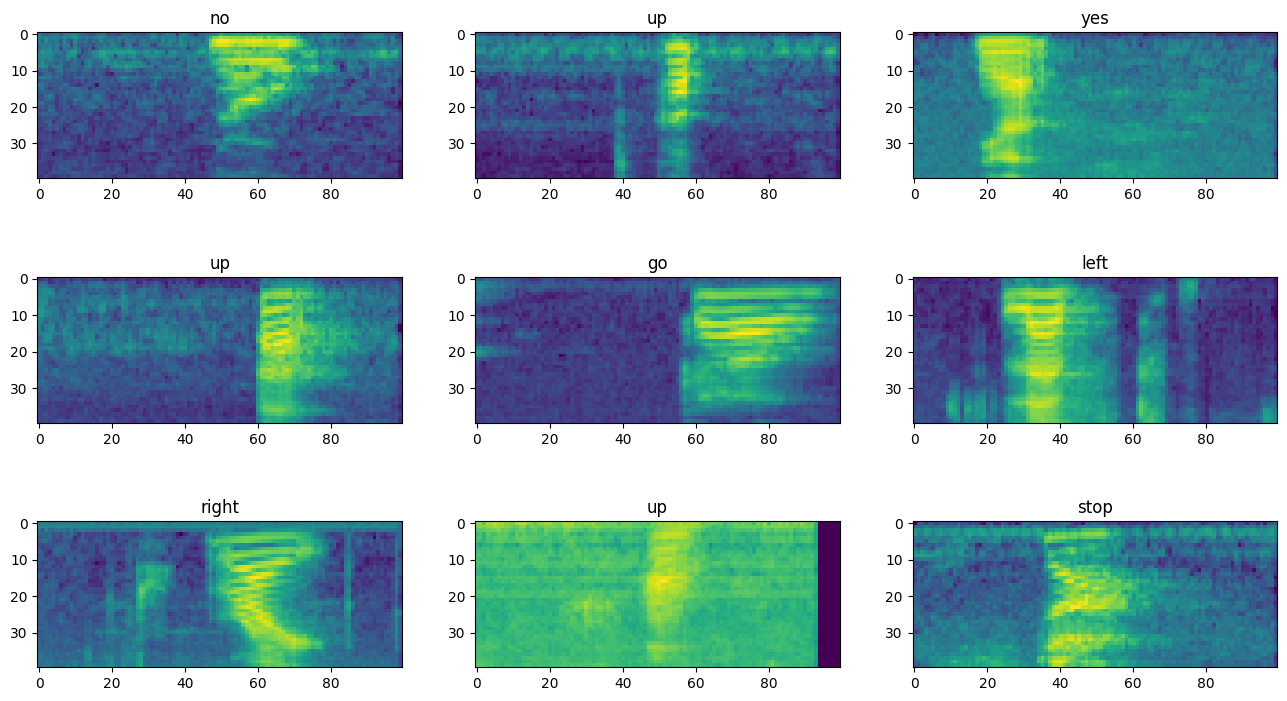

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.imshow(tf.transpose(X_mel[i]))
    ax.set_title(label_names[y[i].numpy()])

plt.show()

In [ ]:
tf.reduce_max(X_mel)

<tf.Tensor: shape=(), dtype=float32, numpy=4.952667>

In [ ]:
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with 'Normalization.adapt'
#norm_layer.adapt(data = train_spectrogram_ds.map(map_func = lambda spec, label: spec))

model = keras.models.Sequential([
    keras.layers.Input(shape = (16000)),
    MelSpectrogram(16000,
                       512,
                       480,
                       160,
                       pad_end = True,
                       n_mels = 40,
                       power = 1,
                       power_to_db = True),
    # Downsample the input.
    keras.layers.Permute((2, 1)),
    keras.layers.Reshape((40, 100, 1)),
    keras.layers.Resizing(32, 32),
    # Normalize
    #norm_layer,
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.Conv2D(64, 3, activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_spectrogram_8 (MelSpec  (None, 100, 40)           0         
 trogram)                                                        
                                                                 
 permute (Permute)           (None, 40, 100)           0         
                                                                 
 reshape_1 (Reshape)         (None, 40, 100, 1)        0         
                                                                 
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
100/100 [==============================] - 29s 269ms/step - loss: 1.8041 - accuracy: 0.3223 - val_loss: 1.1015 - val_accuracy: 0.6328
Epoch 2/5
100/100 [==============================] - 29s 284ms/step - loss: 1.0181 - accuracy: 0.6292 - val_loss: 0.6652 - val_accuracy: 0.7891
Epoch 3/5
100/100 [==============================] - 28s 277ms/step - loss: 0.6685 - accuracy: 0.7583 - val_loss: 0.5137 - val_accuracy: 0.8359
Epoch 4/5
100/100 [==============================] - 32s 316ms/step - loss: 0.5174 - accuracy: 0.8134 - val_loss: 0.4497 - val_accuracy: 0.8581
Epoch 5/5
100/100 [==============================] - 28s 277ms/step - loss: 0.4294 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8815


Text(0, 0.5, 'Accuracy [%]')

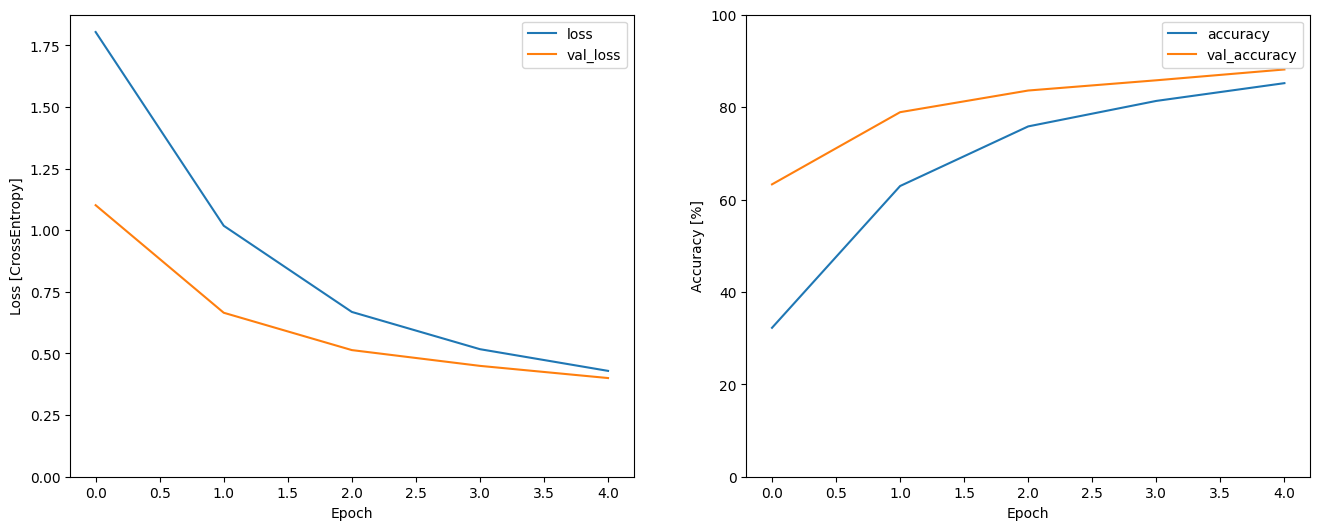

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Convert to TFLite

In [ ]:
X, y = next(iter(train_ds))
X.shape

TensorShape([64, 16000])

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X).batch(1).take(50):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint 8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/gsc_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the dynamic range quantized model:
tflite_model_quant_file = tflite_models_dir/"gsc_tflite_model_quant2.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

1656968

In [ ]:
tflite_model_file = tflite_models_dir/"gsc_model.tflite"
tflite_model_file.write_bytes(tflite_model)

6560892

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_specs

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path = str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), ), dtype = int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_specs[test_image_index]

        # Check if the input type is quantized, the rescale input data to to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details['quantization']
            test_image = test_image/input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis = 0).astype(input_details['dtype'])
        interpreter.set_tensor(input_details['index'], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])[0]

        predictions[i] = output.argmax()

    return predictions

# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_specs
  global test_labels

  test_image_indices = range(test_specs.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_specs)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_specs)))

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 65.6250% (Number of test samples=64)


In [ ]:
evaluate_model(tflite_model_file, model_type="Float32")

Float32 model accuracy is 81.2500% (Number of test samples=64)


In [ ]:
import shutil
shutil.copy2(str(tflite_model_quant_file), '/content')

'/content/gsc_tflite_model_quant2.tflite'